# Hastings Direct Data Science Assessment - Predictive Purchase Behaviour Modelling - Motor Policies
In this notebook, we will construct various machine learning classification models to predict whether or not a customer will purchase a motor policy from Hastings Direct based on quote data. Please note the dataset used in this notebook is property of Hastings Direct.

## Import Packages
In order to import the dataset into Python, visualize the data, etc. we need to import the necessary Python packages into this notebook.

In [1]:
# import necessary Python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from fancyimpute import IterativeImputer
import missingno as msno
from imblearn.over_sampling import SMOTENC
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix
from scipy.stats import randint

# set seed
np.random.seed(seed=2)
random.seed(2)

Using TensorFlow backend.


## Dataset
The dataset to be used in this notebook has the following columns (the data type of each column is given brackets):
- Age: The age of the customer (Continuous).
- Veh_Value: The market value of the vehicle in GBP (Continuous).
- Tax: Insurance Premium Tax Rates which add an additional fee on top of the customer’s price (Continuous).
- Price: The annual price a customer will pay for this policy (Continuous).
- Veh_Mileage: The mileage of the vehicle on this policy (Continuous).
- Credit Score: The customer’s credit score (Continuous).
- License_Length: Amount of time a customer has held their full licence in years (Continuous).
- Date: The date when the policy will start (Date).
- Marital_Status: The customer’s marital status (String).
- Payment_Type: How the customer will pay their price (String).
- Veh_Reg_Year: The year when the vehicle was registered with the DVLA (Integer).
- Sale: Whether or not a policy is sold.

The 'Sale' column is the value that we are required to predict; this is known as the class. The other columns are known as predictors as we are using them to predict the class of a observation. Note that observations belonging to class '0' represent customers that did not purchase a policy, and observations belonging to class '1' represent customers that did purchase a policy. The dataset has been stored in a csv file; in order to analyze and model, we will read the data into a pandas dataframe. Once the data is accessible via a dataframe, the required data wrangling/processing and exploratory data analysis (EDA) will be completed.

In [2]:
# read the dataset into pandas dataframe
policy_data = pd.read_csv('DS_Assessment.csv')
# display first few rows of policy_data dataframe
display(policy_data.head())
# number of observations (rows) in policy data
print('policy_data contains %d observations' %(policy_data.shape[0]))

,Age,Veh_Value,Tax,Price,Veh_Mileage,Credit_Score,License_Length,Date,Marital_Status,Payment_Type,Veh_Reg_Year,Sale
0,68.234601,4385.559975,10.726928,395.881843,7299.380077,366.105677,8.711803,2016-05-14,M,Installments,2017.0,0
1,32.066145,6246.182948,7.869344,534.441400,5887.218868,306.560408,8.754815,2016-06-30,S,Cash,2015.0,0
2,52.039464,5753.093177,9.112318,472.386504,6327.126420,430.070380,6.942515,2016-10-02,M,Installments,2014.0,0
3,51.918920,5674.321541,11.657723,355.692599,7349.979218,493.840343,9.165431,2016-04-06,S,Cash,2011.0,0
4,28.472248,6674.864994,9.309519,327.209088,5471.606750,416.459533,6.810972,2016-10-14,S,Installments,2013.0,0


policy_data contains 50000 observations


In [3]:
# display basic information about policy_data datafrane
policy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
Age               49517 non-null float64
Veh_Value         49475 non-null float64
Tax               49483 non-null float64
Price             49485 non-null float64
Veh_Mileage       49491 non-null float64
Credit_Score      49503 non-null float64
License_Length    49502 non-null float64
Date              49503 non-null object
Marital_Status    49517 non-null object
Payment_Type      49516 non-null object
Veh_Reg_Year      49512 non-null float64
Sale              50000 non-null int64
dtypes: float64(8), int64(1), object(3)
memory usage: 4.6+ MB


In [4]:
# display descriptive statistics about policy_data datafrane (only numerical columns)
display(policy_data.describe())

,Age,Veh_Value,Tax,Price,Veh_Mileage,Credit_Score,License_Length,Veh_Reg_Year,Sale
count,49517.000000,49475.000000,49483.000000,49485.000000,49491.000000,49503.000000,49502.000000,49512.000000,50000.000000
mean,40.513323,6008.619286,10.995845,540.394322,6996.676853,496.283494,7.998617,2013.000909,0.697980
std,13.437293,988.892325,1.063099,135.680353,1327.923420,963.166654,1.994698,2.466044,0.459138
min,18.000000,1837.647794,4.727910,22.949392,1406.334168,55.887237,-0.346291,2008.000000,0.000000
25%,30.452442,5340.690362,10.333460,444.975639,6106.976176,346.341080,6.643690,2012.000000,0.000000
50%,40.303268,6005.285092,11.001785,549.330866,6998.198119,400.250070,8.007871,2013.000000,1.000000
75%,49.869251,6676.189181,11.661439,638.323917,7888.930249,455.046589,9.342741,2015.000000,1.000000
max,93.559448,10047.187780,16.244017,994.190554,12795.519718,9999.000000,16.403324,2017.000000,1.000000


In [5]:
# display total number of missing values in policy_data datafrane by column
display(policy_data.isnull().sum())
# display total number of missing values in policy_data dataframe
print('policy_data has %d missing values' %(policy_data.isnull().sum().sum()))

Age               483
Veh_Value         525
Tax               517
Price             515
Veh_Mileage       509
Credit_Score      497
License_Length    498
Date              497
Marital_Status    483
Payment_Type      484
Veh_Reg_Year      488
Sale                0
dtype: int64

policy_data has 5496 missing values


## Data Wrangling/Processing and EDA

In this subsection, we will perform the required data wrangling/processing to get the data ready for modelling. Furthermore, we will conduct various EDA to identify any anomalies and trends in the data.

From the previous section (basic information of policy_data dataframe), we observe that the 'Date' predictor is a object data type. As this predictor is representing a date, we will convert it into a datetime data type. Note that date predictors cannot be read by machine learning models in their current format (i.e. yyyy-mm-dd), and therefore need to be engineered into a meaningful numerical feature. We will see if the month of the inception of the policies have any seasonality, and use this as a new predictor. The 'Date' predictor will be removed once the new predictor has been engineered. We also observe that the policy_data dataframe contains a significant amount of missing values (~11% of observations contain missing values); these will be addressed using a imputation method known as Multiple Imputation by Chained Equations (MICE) to avoid discarding data. Categorical predictor columns (e.g. Marital_Status) will be label encoded as machine learning models can only interpret numerical values.

Boxplots will be used to identify any extreme outliers that might be contained in any of the continuous-valued predictor columns of the policy_data dataframe. Furthermore, the correlation between each numerical feature will be calaculated and displayed on a heatmap to give us a better insight on which columns are correlated and which are not. The extent of any class imbalance will be analyzed and visualized; if a class imbalance is present within the policy_data dataframe, we will use a suitable over-sampling technique to address the problem. The distrubtion of customer ages separated by whether or not they purchase a policy will also be visualized to get a good idea of which age groups convert quotes and do not convert quotes into policies. Lastly, the distribution of prices for motor policies broken down by class and age might aid in maximizing income through identying which group of customers are more likely to purchase a policy.

In [6]:
# convert Date predictor column of policy_data dataframe into datetime data type
policy_data['Date'] = pd.to_datetime(policy_data['Date'])
# check if year of policy inceptions are identical (or missing)
policy_data['Date'].dt.year.unique()

array([2016.,   nan])

In [8]:
# create new predictor column in policy_data dataframe to store the month of incpetion 
policy_data['Inception_Month'] = policy_data['Date'].dt.month
# move Inception_Month predictor next to 'Date' predictor in policy_data dataframe
columns = policy_data.columns.tolist()
columns = columns[:8] + columns[-1:] + columns[8:-1]
policy_data = policy_data[columns]

# remove Date predictor column from policy_data dataframe
policy_data = policy_data.drop(['Date'], axis=1)

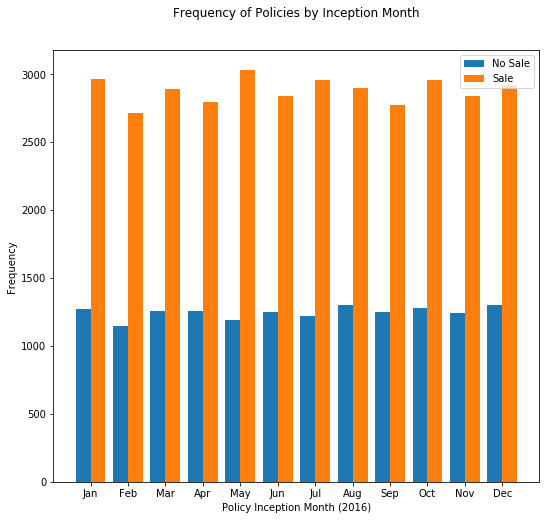

In [9]:
# visualize Inception_Month separated by class to uncover any seasonality in sales or no sales in motor policies
# pyplot subplot
fig, axes = plt.subplots(figsize=(7.5, 7.5))

# plot frequency of Inception Month belonging to Sale of 0 (customer did not buy the policy)
no_sale_month_freq = policy_data.query('Sale==0')['Inception_Month'].value_counts().sort_index()
bar_one = axes.bar(no_sale_month_freq.index, no_sale_month_freq.values, width=0.4)
# plot frequency of Inception Month belonging to Sale of 1 (customer did buy the policy)
sale_month_freq = policy_data.query('Sale==1')['Inception_Month'].value_counts().sort_index()
bar_two = axes.bar(sale_month_freq.index+0.4, sale_month_freq.values, width=0.4)

# set x-y axis labels of grouped bar plot
plt.xlabel('Policy Inception Month (2016)')
plt.ylabel('Frequency')
# set title of grouped bar plot
plt.suptitle('Frequency of Policies by Inception Month')
# set position of x axis tick labels of grouped bar plot
axes.set_xticks(sale_month_freq.index+0.4 / 2)
# re-label x axis tick labels of grouped bar plot
axes.set_xticklabels(('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
# legend of grouped bar plot
axes.legend((bar_one[0], bar_two[0]), ('No Sale', 'Sale'))

# adjust spacing properties of subplot
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9,
                    hspace=0.2, wspace=0.2)

# display grouped bar plot
plt.show()

From the grouped bar plot above, we observe that May is the month in which the most motor quotes were converted into policies by customers. Furthermore, January, October, and December are months in which a significant amount of quotes were converted to policies. Note that we notice that there is a significant class imbalance within the dataset (i.e. there are significantly more observations that represent a sale than no sale; the class imbalance will be addressed using a over-sampling technique known as Synthetic Minority Over-Sampling Technique (SMOTE) shortly. Whilst December is a month in which a significant amount of policies were sold, it is also a month in which the most amount of quotes did not get converted into policies.  

In [10]:
# label encode categorical predictor columns in policy_data dataframe
# loop through observations of policy_data dataframe
for idx, row in policy_data.iterrows():
    # Marital_Status predictor
    if row['Marital_Status'] == 'M':
        policy_data.loc[idx, 'Marital_Status'] = 0
    elif row['Marital_Status'] == 'S':
        policy_data.loc[idx, 'Marital_Status'] = 1
    elif row['Marital_Status'] == 'D':
         policy_data.loc[idx, 'Marital_Status'] = 2
    else:
        pass
    # Payment_Type predictor
    if row['Payment_Type'] == 'Installments':
        policy_data.loc[idx, 'Payment_Type'] = 0
    elif row['Payment_Type'] == 'Cash':
        policy_data.loc[idx, 'Payment_Type'] = 1
    else:
        pass

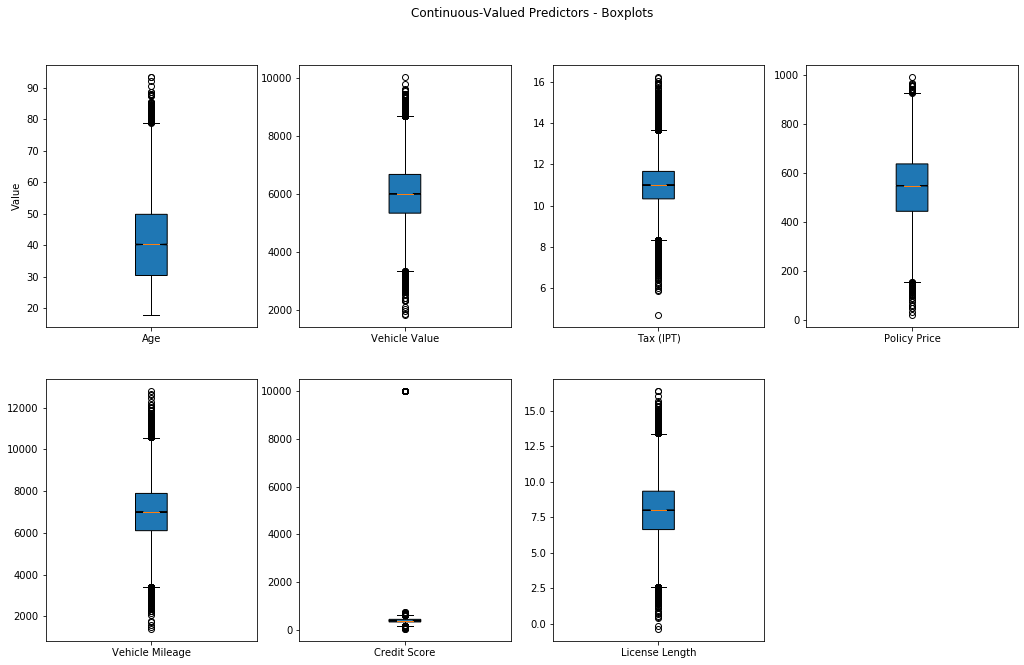

In [11]:
# create boxplots for continuous-valued predictor columns of the policy_data dataframe
# # pyplot subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

# plot Age predictor values on boxplot
axes[0, 0].boxplot(policy_data['Age'].dropna(), patch_artist=True, notch=True)
plt.sca(axes[0, 0])
plt.xticks([1], ['Age'])
plt.ylabel('Value')

# plot Veh_Value predictor values on boxplot
axes[0, 1].boxplot(policy_data['Veh_Value'].dropna(), patch_artist=True, notch=True)
plt.sca(axes[0, 1])
plt.xticks([1], ['Vehicle Value'])

# plot Tax predictor values on boxplot
axes[0, 2].boxplot(policy_data['Tax'].dropna(), patch_artist=True, notch=True)
plt.sca(axes[0, 2])
plt.xticks([1], ['Tax (IPT)'])

# plot Price predictor values on boxplot
axes[0, 3].boxplot(policy_data['Price'].dropna(), patch_artist=True, notch=True)
plt.sca(axes[0, 3])
plt.xticks([1], ['Policy Price'])

# plot Veh_Mileage predictor values on boxplot 
axes[1, 0].boxplot(policy_data['Veh_Mileage'].dropna(), patch_artist=True, notch=True)
plt.sca(axes[1, 0])
plt.xticks([1], ['Vehicle Mileage'])

# plot Credit_Score predictor values on boxplot
axes[1, 1].boxplot(policy_data['Credit_Score'].dropna(), patch_artist=True, notch=True)
plt.sca(axes[1, 1])
plt.xticks([1], ['Credit Score'])

# plot License_Length predictor values on boxplot
axes[1, 2].boxplot(policy_data['License_Length'].dropna(), patch_artist=True, notch=True)
plt.sca(axes[1, 2])
plt.xticks([1], ['License Length'])

# delete axes on 2nd row and 4th column as this is not required
fig.delaxes(axes[1, 3])

# set title of subplot figure
fig.suptitle('Continuous-Valued Predictors - Boxplots')

# adjust spacing properties of subplot
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9,
                    hspace=0.2, wspace=0.2)

# display boxplots
plt.show()

From the boxplots above, we observe that every continuous-valued predictor column in the policy_data dataframe contains 'expected' outliers. However, the Credit_Score predictor has a few 'extreme' outliers meaning that its descriptive statistics (e.g. standard deviation) could possibly be skewed. Credit scores are usually scored from 0 to 1000, and therefore any outlier that is not in this boundary will be set to a null value; these will be estimated with MICE when addressing the missing values in the rest of the dataset.

In [12]:
# find the number of observations with Credit_Score greater than 1000 (from the box plot, there does not seem to be any values below 0)
print('There are %d observations with extreme-valued credit scores' %(policy_data.query('Credit_Score>1000').shape[0]))
# set Credit_Score to NaN if Credit_Score > 1000
for idx, row in policy_data.iterrows():
    if row['Credit_Score'] > 1000:
        policy_data.loc[idx, 'Credit_Score'] = float('nan')
print('These values have been set to NaN')

There are 500 observations with extreme-valued credit scores
These values have been set to NaN


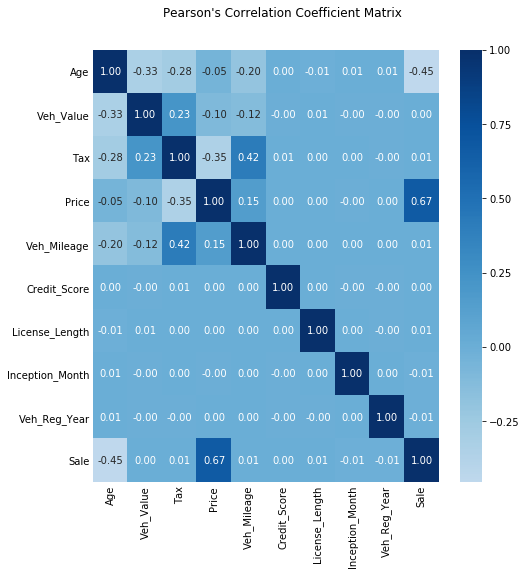

In [13]:
# create correlation heatmap for numerical-valued predictor columns and class column of the policy_data dataframe
# pyplot subplots
fig, axes = plt.subplots(figsize=(7.5, 7.5))

# plot seaborn heatmap using pearson's correlation coefficient
sns.heatmap(policy_data.corr(method='pearson'), cmap='Blues', annot=True, fmt='.2f', center=0, ax=axes)
axes.tick_params(axis='both', which='both', length=0)

# adjust spacing properties of subplot
fig.subplots_adjust(left=0.15, right=0.95, bottom=0.1, top=0.9,
                    hspace=0.2, wspace=0.2)
# set title of subplot figure
fig.suptitle('Pearson\'s Correlation Coefficient Matrix')

# display heatmap
plt.show()

The heatmap of Pearson's Correlation Coefficient shows the price of a motor policy has a strong positive correlation with the class column (Sale). This would be expected as a customer is more likely to purchase a cheaper policy than an expensive policy. A odd correlation exists between customers' vehicle value (and vehicle mileage() with the IPT (Tax) amount of a policy. Furthermore, it can be observed that a customers' age is negatively correlated with the class column. Various odd and unexplainable correlations (e.g. correlation betweeen customers' vehicle value and IPT) could be due to the class imbalance or missing values. A reproduction of this correlation matrix will be produced when the class imbalance and missing values have been addressed. 

C:\Users\Axil Sudra\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Axil Sudra\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


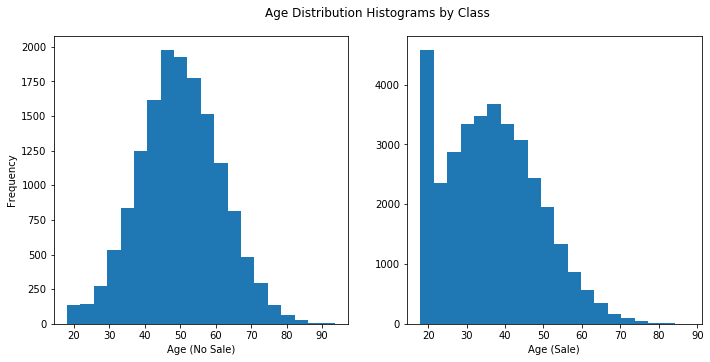

In [14]:
# create a histogram for the Age predictor column in the policy_data dataframe (observations that have not purchased policy vs observations that have purchased policy)
# pyplot subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# plot age of customers that have not purchased a policy
axes[0].hist(policy_data.query('Sale==0')['Age'], bins=20)
plt.sca(axes[0])
plt.xlabel('Age (No Sale)')
plt.ylabel('Frequency')

# plot age of customers that have purchased a policy
axes[1].hist(policy_data.query('Sale==1')['Age'], bins=20)
plt.sca(axes[1])
plt.xlabel('Age (Sale)')

# adjust spacing properties of subplot
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9,
                    hspace=0.2, wspace=0.2)
# set title of subplot figure
fig.suptitle('Age Distribution Histograms by Class')

# display histogram plots
plt.show()

The hsitogram on the left above show that the data for the Age predictor column that belong to the class that represents no policy sale is normally distributed. Customers aged between 40 and 50 are the most unlikely to convert their motor quotes into policies. The histogram on the right shows that young motorists (aged in their low 20s) are the most likely to convert their quotes into policies; note that the data contained in this histogram is skewed to the left.

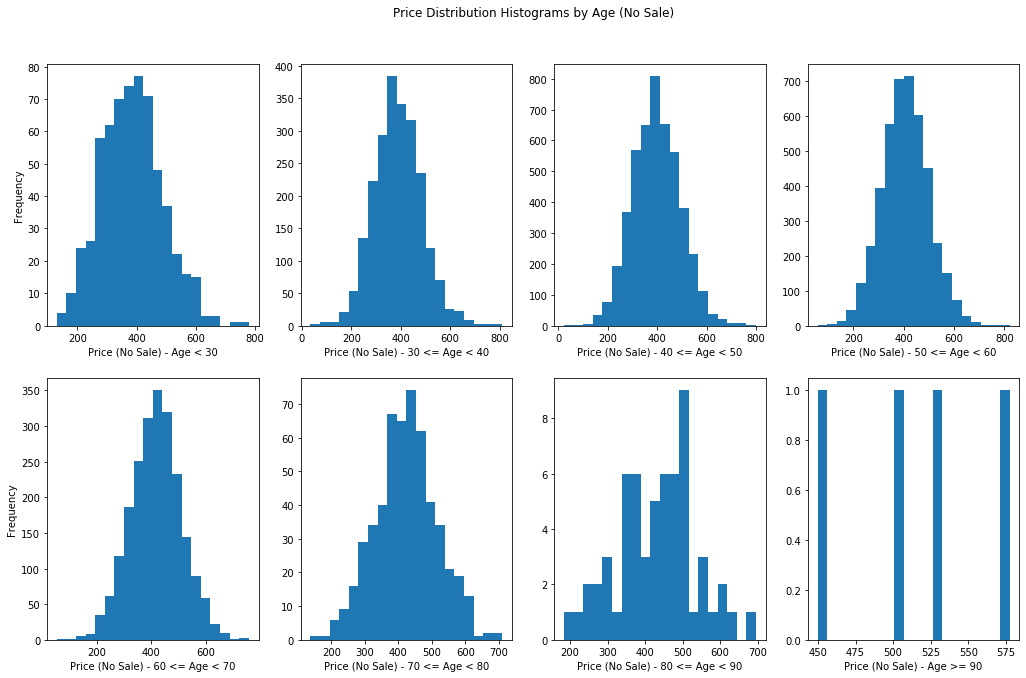

In [15]:
# create a histogram for the Price predictor column in the policy_data dataframe broken down by age and class (observations that have not purchased policy)
# pyplot subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))

# plot price of customers that have not purchased a policy
axes[0, 0].hist(policy_data.query('Sale==0 & Age < 30')['Price'], bins=20)
plt.sca(axes[0, 0])
plt.xlabel('Price (No Sale) - Age < 30')
plt.ylabel('Frequency')

axes[0, 1].hist(policy_data.query('Sale==0 & Age >= 30 & Age < 40')['Price'], bins=20)
plt.sca(axes[0, 1])
plt.xlabel('Price (No Sale) - 30 <= Age < 40')

axes[0, 2].hist(policy_data.query('Sale==0 & Age >= 40 & Age < 50')['Price'], bins=20)
plt.sca(axes[0, 2])
plt.xlabel('Price (No Sale) - 40 <= Age < 50')

axes[0, 3].hist(policy_data.query('Sale==0 & Age >= 50 & Age < 60')['Price'], bins=20)
plt.sca(axes[0, 3])
plt.xlabel('Price (No Sale) - 50 <= Age < 60')

axes[1, 0].hist(policy_data.query('Sale==0 & Age >= 60 & Age < 70')['Price'], bins=20)
plt.sca(axes[1, 0])
plt.xlabel('Price (No Sale) - 60 <= Age < 70')
plt.ylabel('Frequency')

axes[1, 1].hist(policy_data.query('Sale==0 & Age >= 70 & Age < 80')['Price'], bins=20)
plt.sca(axes[1, 1])
plt.xlabel('Price (No Sale) - 70 <= Age < 80')

axes[1, 2].hist(policy_data.query('Sale==0 & Age >= 80 & Age < 90')['Price'], bins=20)
plt.sca(axes[1, 2])
plt.xlabel('Price (No Sale) - 80 <= Age < 90')

axes[1, 3].hist(policy_data.query('Sale==0 & Age >= 90')['Price'], bins=20)
plt.sca(axes[1, 3])
plt.xlabel('Price (No Sale) - Age >= 90')

# adjust spacing properties of subplot
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9,
                    hspace=0.2, wspace=0.2)
# set title of subplot figure
fig.suptitle('Price Distribution Histograms by Age (No Sale)')

# display histogram plots
plt.show()

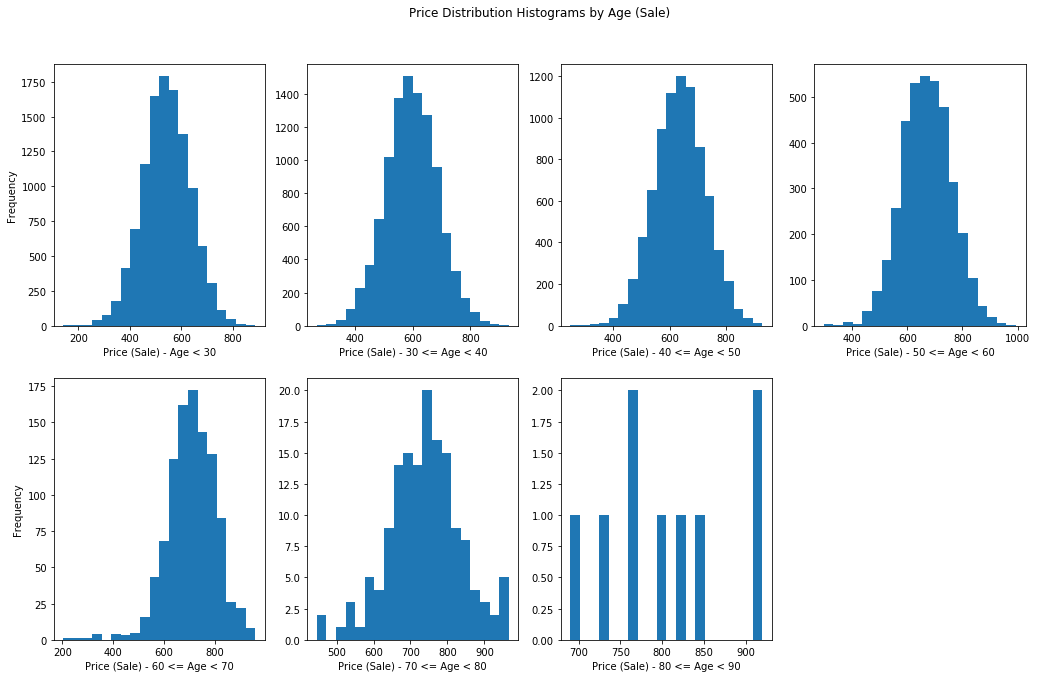

In [16]:
# create a histogram for the Price predictor column in the policy_data dataframe broken down by age and class (observations that have purchased policy)
# pyplot subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))

# plot price of customers that have not purchased a policy
axes[0, 0].hist(policy_data.query('Sale==1 & Age < 30')['Price'], bins=20)
plt.sca(axes[0, 0])
plt.xlabel('Price (Sale) - Age < 30')
plt.ylabel('Frequency')

axes[0, 1].hist(policy_data.query('Sale==1 & Age >= 30 & Age < 40')['Price'], bins=20)
plt.sca(axes[0, 1])
plt.xlabel('Price (Sale) - 30 <= Age < 40')

axes[0, 2].hist(policy_data.query('Sale==1 & Age >= 40 & Age < 50')['Price'], bins=20)
plt.sca(axes[0, 2])
plt.xlabel('Price (Sale) - 40 <= Age < 50')

axes[0, 3].hist(policy_data.query('Sale==1 & Age >= 50 & Age < 60')['Price'], bins=20)
plt.sca(axes[0, 3])
plt.xlabel('Price (Sale) - 50 <= Age < 60')

axes[1, 0].hist(policy_data.query('Sale==1 & Age >= 60 & Age < 70')['Price'], bins=20)
plt.sca(axes[1, 0])
plt.xlabel('Price (Sale) - 60 <= Age < 70')
plt.ylabel('Frequency')

axes[1, 1].hist(policy_data.query('Sale==1 & Age >= 70 & Age < 80')['Price'], bins=20)
plt.sca(axes[1, 1])
plt.xlabel('Price (Sale) - 70 <= Age < 80')

axes[1, 2].hist(policy_data.query('Sale==1 & Age >= 80 & Age < 90')['Price'], bins=20)
plt.sca(axes[1, 2])
plt.xlabel('Price (Sale) - 80 <= Age < 90')

axes[1, 3].hist(policy_data.query('Sale==1 & Age >= 90')['Price'], bins=20)
plt.sca(axes[1, 3])
plt.xlabel('Price (Sale) - Age >= 90')

# delete axes on 2nd row and 4th column as this is not required
fig.delaxes(axes[1, 3])

# adjust spacing properties of subplot
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9,
                    hspace=0.2, wspace=0.2)
# set title of subplot figure
fig.suptitle('Price Distribution Histograms by Age (Sale)')

# display histogram plots
plt.show()

From the histogram subplots above, we observe that customers aged between 40 and 60 are more likely not to purchase a policy; this age group might not be willing to purchase a motor policy for the average price (~ £400). On the other hand, customers aged between 18 and 40 are more likely to convert their quote into a policy at a relatively high price (~ £500). Therefore, increasing marketing costs for customers aged between 18 and 40 might maximize income, and decreasing marketing costs for customers aged between 40 and 60 might help cut costs.

## Dealing with Missing Values
In this subsection we will visualize the extent of our missing value problem in the policy_data dataframe, and use a imputation method known as Multiple Imputations by Chained Equations (MICE) to estimate these missing values. As shown previously, there 5496 values that are missing from the policy_data dataframe

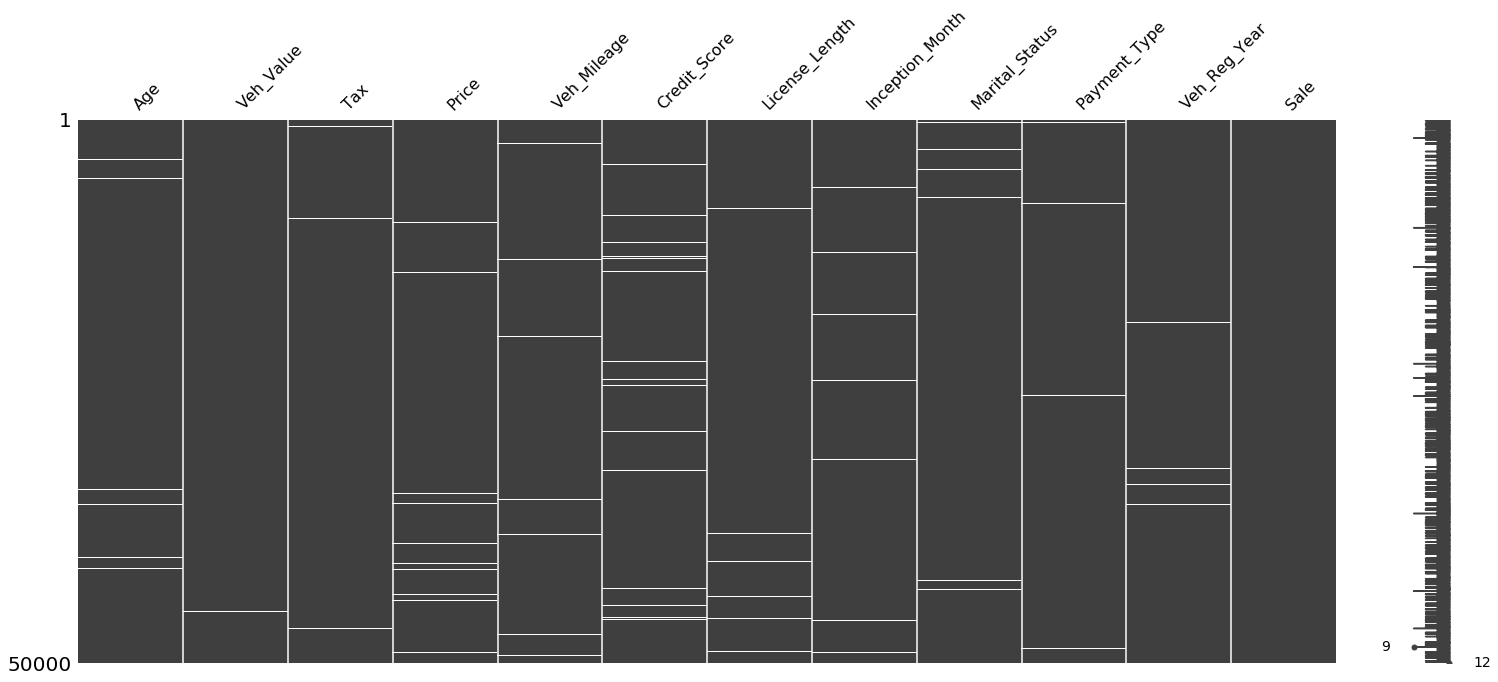

In [17]:
# visualize missing values for each column of the policy_data dataframe
msno.matrix(policy_data)

The matrix above depicts the positioning of the missing values in the policy_data dataframe. Note that the white lines contained in each column denotes missing values. It can be concluded that the missing values can be classed as missing at random (e.g. the data is missing at random although can be generally be estimated from existing values) and/or not missing at random (e.g. some people might be secrective about age). Therefore, we can use a imputation method to address the missing values.

In [18]:
# create a copy of the policy_data dataframe
policy_data_imputed = policy_data.copy(deep=True)

# initialize IterativeImputer
mice_imputer = IterativeImputer(random_state=2)
# impute missing values using fit_transform function of IterativeImputer()
policy_data_imputed.iloc[:, :] = mice_imputer.fit_transform(policy_data)

# round missing value estimates for categorical predictor columns
policy_data_imputed['Marital_Status'] = round(policy_data_imputed['Marital_Status'])
policy_data_imputed['Payment_Type'] = round(policy_data_imputed['Payment_Type'])
policy_data_imputed['Veh_Reg_Year'] = round(policy_data_imputed['Veh_Reg_Year'])
policy_data_imputed['Inception_Month'] = round(policy_data_imputed['Inception_Month'])

In [19]:
# display number of missing values in the policy_data_imputed dataframe
print('policy_data_imputed has %d missing values' %(policy_data_imputed.isnull().sum().sum()))

policy_data_imputed has 0 missing values


As we can see from the result in the call above, MICE has estimated the missing values of the policy_data dataframe. We now visualize the correlation matrix that was used previously to identify any changes.

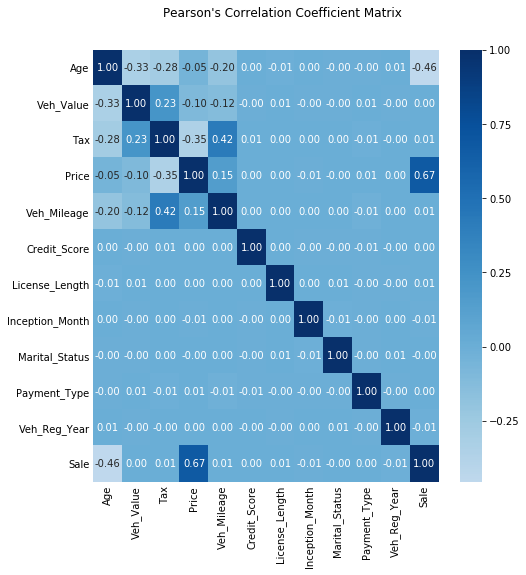

In [20]:
# create correlation heatmap for numerical-valued predictor columns and class column of the policy_data_imputed dataframe
# pyplot subplots
fig, axes = plt.subplots(figsize=(7.5, 7.5))

# plot seaborn heatmap using pearson's correlation coefficient
sns.heatmap(policy_data_imputed.corr(method='pearson'), cmap='Blues', annot=True, fmt='.2f', center=0, ax=axes)
axes.tick_params(axis='both', which='both', length=0)

# adjust spacing properties of subplot
fig.subplots_adjust(left=0.15, right=0.95, bottom=0.1, top=0.9,
                    hspace=0.2, wspace=0.2)
# set title of subplot figure
fig.suptitle('Pearson\'s Correlation Coefficient Matrix')

# display heatmap
plt.show()

Suprisingly, there has been little change in the correlation between numerical-valued columns in the policy_data_imputed dataframe. The corrleation between the Age predictor column and the class column has changed the most (been reduced) which would be expected from the previous histograms. 

## Dealing with Imbalanced Dataset
As mentioned previously, our dataset has a signicant class imbalance; the problem of a imbalanced dataset could lead to a given machine learning model predicting one class very welll and the other class not so well if not addressed appropriately. To avoid discarding any data from the policy_data_imputed data, we will use the Synthetic Minority Over-Sampling Technique (SMOTE) algorithm to address our class imbalance. Note that the SMOTENC module will be used to handle continuous and categorical variables.

In [21]:
# retrieve the number of observations belonging to each class in the policy_data_imputed datafrane
policy_no_sale = policy_data_imputed.query('Sale==0').shape[0]
policy_sale = policy_data_imputed.query('Sale==1').shape[0]

# create dataframe to store class information
class_info = pd.DataFrame(columns=['No_Sale', 'Sale'], index=['Frequency', 'Proportion'])
class_info.loc['Frequency', 'No_Sale'] = policy_no_sale
class_info.loc['Frequency', 'Sale'] = policy_sale
class_info.loc['Proportion', 'No_Sale'] = round(policy_no_sale/policy_data_imputed.shape[0], 2)
class_info.loc['Proportion', 'Sale'] = round(policy_sale/policy_data_imputed.shape[0], 2)

# display closs_info dataframe
display(class_info)

,No_Sale,Sale
Frequency,15101,34899
Proportion,0.3,0.7


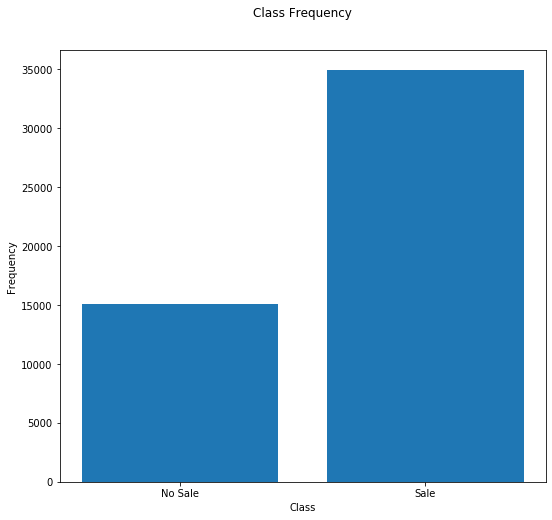

In [22]:
# visualize class imbalance with bar plot
# pyplot subplots
fig, axes = plt.subplots(figsize=(7.5, 7.5))

# plot frequecy of each class
axes.bar(['No Sale', 'Sale'], class_info.loc['Frequency'])

# set x-y axis labels
plt.xlabel('Class')
plt.ylabel('Frequency')

# set title of grouped bar plot
plt.suptitle('Class Frequency')
# adjust spacing properties of subplot
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9,
                    hspace=0.2, wspace=0.2)

# display grouped bar plot
plt.show()

In [23]:
# apply SMOTE to policy_data_imputed dataframe
# initialize SMOTENC module
smt = SMOTENC(random_state=2, categorical_features=[7, 8, 9, 10])

# fit smt to policy_data_impute dataframe
X, y = smt.fit_sample(policy_data_imputed.drop(['Sale'], axis=1), policy_data_imputed['Sale'])

In [24]:
# retrieve frequency of class that represents no sale
print('Frequency of no sale class %d' %(Counter(y)[0]))
# retrieve frequency of class that represents sale
print('Frequency of sale class %d' %(Counter(y)[1]))

Frequency of no sale class 34899
Frequency of sale class 34899


From the result in the cell above, we notice that the SMOTE algorithm has successfully re-balanced our dataset, and now each class has the same amount of observations. 

In [25]:
# for ease of access, store predictor column values in X in new dataframe
X_data = pd.DataFrame(X, columns=['Age', 'Veh_Value', 'Tax', 'Price', 'Veh_Mileage', 'Credit_Score', 'License_Length', 
                                           'Inception_Month', 'Marital_Status', 'Payment_Type', 'Veh_Reg_Year'])
# for ease of access, store class column values in y in new dataframe
y_data = pd.DataFrame(y, columns=['Sale'])

## One Hot Encoding of Categorical Variables
To aid a given machine learning model at interpreting categorical predictor values, we will one hot encoded their values (i.e. represent as a binary system). These as well as the continuous-valued predictor columns will be stored in a new dataframe once feature scaling has been completed on continuous-valued predictor columns.

In [26]:
# hot one encode for Marital_Status predictor column of X_data dataframe
marital_status_data = pd.get_dummies(X_data['Marital_Status']).rename(columns={0:'M', 1:'S', 2:'D'})
# hot one encode for Payment_Type predictor column of X_data dataframe
payment_type_data = pd.get_dummies(X_data['Payment_Type']).rename(columns={0:'Installments', 1:'Cash'})
# hot one encode for Veh_Reg_Year predictor column of X_data dataframe
veh_reg_year_year = pd.get_dummies(X_data['Veh_Reg_Year'])
# hot one encode Inception_Month predictor column of X_data dataframe
inception_month = pd.get_dummies(X_data['Inception_Month']).rename(columns={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug',
                                                                            9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})

## Feature Scaling
As the continuous-valued predictor columns in the X_data dataframe are of various magnitude, we will scale them using the standard deviation scaler; this helps a given machine learning algorithm with computation and also uncovering complex relationships when the predictor values are close together.

In [27]:
# Initialize the Scaler 
scaler = StandardScaler()
# To scale data 
contiuous_pred_data = scaler.fit_transform(X_data.drop(columns=['Inception_Month', 'Marital_Status', 'Payment_Type', 'Veh_Reg_Year']))

# create dataframe for contiuous_pred_data dataframe for ease of access
contiuous_pred_data = pd.DataFrame(contiuous_pred_data, columns=['Age', 'Veh_Value', 'Tax', 'Price', 'Veh_Mileage', 'Credit_Score', 'License_Length'])

In [28]:
# create new dataframe with hot one encoded categorical predictor columns and contiuous_pred_data dataframe
X_data_hot = pd.concat([contiuous_pred_data, inception_month, marital_status_data, payment_type_data, veh_reg_year_year], axis=1)

## Train/Test Split
As we are creating machine learning models, we are required to split the dataset into a training set and a test set. Note that we will use a 75%/25% train/test split in this notebook.

In [29]:
# create train and test set using sklearn train_test_split module
X_train, X_test, y_train, y_test = train_test_split(X_data_hot, y_data, test_size=0.25, random_state=2)

## Random Forest Classifier
The first machine model we will create will be a Random Forest Classifier. Note that we will use the sklearn module RandomizedSearchCV to source the 'best' hyperparameters for the model; this module will also carry out cross-validation on the training set. We will use 5-fold cross validation. Once the 'best' hyperparameters are sourced, we will train a new model on them and calculate various performance metrics (e.g. accurarcy). A confusion matrix and roc curve will also be plotted.

In [30]:
# initialize random forest classifier
rfc = RandomForestClassifier(random_state=2)

# specify parameter values that are to be explored when conducting random search
rfc_param_dist = {'n_estimators':randint(100, 1000),
                 'max_features':['auto', 'sqrt', 'log2'],
                 'max_depth':randint(3, 10),
                 'criterion':['gini', 'entropy']}

# conduct grid search and source model with best parameters
rs_cv_rfc = RandomizedSearchCV(estimator=rfc, param_distributions=rfc_param_dist, cv=5, n_iter=2, random_state=2, verbose=2)
# fit grid search to training data
rs_cv_rfc.fit(X_train, y_train['Sale'].to_numpy())

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=634 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=634, total=  29.2s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=634 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.1s remaining:    0.0s


[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=634, total=  26.3s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=634 
[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=634, total=  27.0s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=634 
[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=634, total=  26.9s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=634 
[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=634, total=  27.0s
[CV] criterion=entropy, max_depth=5, max_features=auto, n_estimators=363 
[CV]  criterion=entropy, max_depth=5, max_features=auto, n_estimators=363, total=  13.8s
[CV] criterion=entropy, max_depth=5, max_features=auto, n_estimators=363 
[CV]  criterion=entropy, max_depth=5, max_features=auto, n_estimators=363, total=  13.9s
[CV] criterion=entropy, max_depth=5, max_features=auto, n_estimators=363 
[CV]  criterion=entropy, max_depth=5, max_f

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.4min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [31]:
# display best set of hyperparameters from randomized search
rs_cv_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 634}

In [32]:
# train new random forest model on best hyperparameters
rfc_best = RandomForestClassifier(random_state=2, criterion=rs_cv_rfc.best_params_['criterion'], max_depth=rs_cv_rfc.best_params_['max_depth'],  
                                  max_features=rs_cv_rfc.best_params_['max_features'], n_estimators=rs_cv_rfc.best_params_['n_estimators'])
# fit model to training set data
rfc_best.fit(X_train, y_train['Sale'].to_numpy())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=634,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

In [33]:
# predict class labels for test set data
y_pred = rfc_best.predict(X_test)

# create confusion matrix for test set data to calculate performance metrics
rfc_con_matrix = confusion_matrix(y_test['Sale'].to_numpy(), y_pred)

In [34]:
# retrieve true positive, true negative, false positive, and false negative values from rfc_con_matrix
tn = rfc_con_matrix[0][0]
fp = rfc_con_matrix[0][1]
fn = rfc_con_matrix[1][0]
tp = rfc_con_matrix[1][1]
# calculate the accuracy of the random forest model on the test set
rfc_accurarcy = (tp+tn)/(tp+tn+fp+fn)
# calculate the precision of the random forest model on the test set
rfc_precision = tp/(tp+fp)
# calculate the recall of the random forest model on the test set
rfc_recall = tp/(tp+fn)
# calculate the f1-score of the random forest model on the test set
rfc_f1_score = (2*(rfc_recall*rfc_precision))/(rfc_precision+rfc_recall)

# display random forest classifier model performance metrics calculated above
print('Random forest classifier accuracy: %.4f%%' %(rfc_accurarcy*100))
print('Random forest classifier precision: %.4f' %(rfc_precision))
print('Random forest classifier recall: %.4f' %(rfc_recall))
print('Random forest classifier f1-score: %.4f' %(rfc_f1_score))

Random forest classifier accuracy: 95.3582%
Random forest classifier precision: 0.9433
Random forest classifier recall: 0.9648
Random forest classifier f1-score: 0.9539


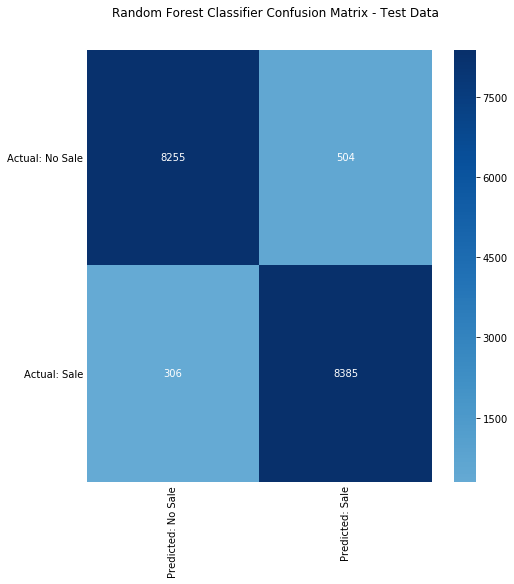

In [35]:
# visualize confusion matrix on seaborn heatmap
# pyplot subplots
fig, axes = plt.subplots(figsize=(7.5, 7.5))

# plot rfc_con_matrix on seaborn heatmap
sns.heatmap(rfc_con_matrix, cmap='Blues', annot=True, fmt='d', center=0, ax=axes)
# adjust rotation of x tick labels and y tick labels
axes.set_yticklabels(['Actual: No Sale', 'Actual: Sale'], rotation=0)
axes.set_xticklabels(['Predicted: No Sale', 'Predicted: Sale'], rotation=90)
# set tick properties
axes.tick_params(axis='both', which='both', length=0)

# adjust spacing properties of subplot
fig.subplots_adjust(left=0.15, right=0.95, bottom=0.1, top=0.9,
                    hspace=0.2, wspace=0.2)

# set title of subplot figure
fig.suptitle('Random Forest Classifier Confusion Matrix - Test Data')

# display heatmap
plt.show()

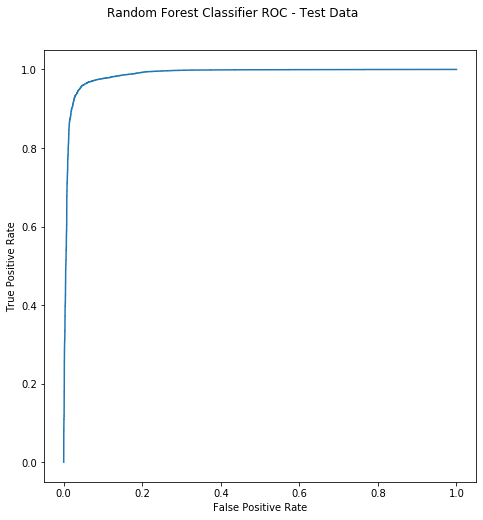

In [36]:
# plot roc curve for random forest classifier
# pyplot subplots
fig, axes = plt.subplots(figsize=(7.5, 7.5))

# obtain probabilities for roc curve
rfc_fpr, rfc_tpr, rfc_thresholds = roc_curve(y_test['Sale'].to_numpy(), rfc_best.predict_proba(X_test)[:, 1])

# plot true positive and false positive rates
plt.plot(rfc_fpr, rfc_tpr)
# set x-y axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# adjust spacing properties of subplot
fig.subplots_adjust(left=0.15, right=0.95, bottom=0.1, top=0.9,
                    hspace=0.2, wspace=0.2)

# set title of subplot figure
fig.suptitle('Random Forest Classifier ROC - Test Data')

# display roc
plt.show()

In [37]:
# display area under curve for random forest classifier
print('Random forest classifier - area under curve: %.4f' %(auc(rfc_fpr, rfc_tpr)))

Random forest classifier - area under curve: 0.9874


## Support Vector Machine
The second machine model we will create will be a Support Vector Machine. The same procedure will be followed as that of the Random Forest Classifier above.

In [38]:
# initialize random support vector classifier
svc = SVC(random_state=2)

# specify values for C and gamma hyperparameter
g_range = np.random.uniform(0.0001, 1, 40).astype(float)
C_range = np.random.normal(0.0001, 1, 40).astype(float)
 
# Check that gamma > 0 and C > 0 
C_range[C_range < 0] = 0.0001
g_range[g_range < 0] = 0.0001

# specify parameter values that are to be explored when conducting random search
svc_param_dist = {'C':list(C_range),
                 'kernel':['rbf', 'linear', 'sigmoid', 'poly'],
                 'gamma':list(g_range)}

# conduct grid search and source model with best parameters
rs_cv_svc = RandomizedSearchCV(estimator=svc, param_distributions=svc_param_dist, cv=5, n_iter=2, random_state=2, verbose=2)
# fit grid search to training data
rs_cv_svc.fit(X_train, y_train['Sale'].to_numpy())

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] kernel=poly, gamma=0.435378860379015, C=0.43359633007657084 .....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  kernel=poly, gamma=0.435378860379015, C=0.43359633007657084, total=  49.7s
[CV] kernel=poly, gamma=0.435378860379015, C=0.43359633007657084 .....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.6s remaining:    0.0s


[CV]  kernel=poly, gamma=0.435378860379015, C=0.43359633007657084, total=  51.2s
[CV] kernel=poly, gamma=0.435378860379015, C=0.43359633007657084 .....
[CV]  kernel=poly, gamma=0.435378860379015, C=0.43359633007657084, total=  51.2s
[CV] kernel=poly, gamma=0.435378860379015, C=0.43359633007657084 .....
[CV]  kernel=poly, gamma=0.435378860379015, C=0.43359633007657084, total=  46.3s
[CV] kernel=poly, gamma=0.435378860379015, C=0.43359633007657084 .....
[CV]  kernel=poly, gamma=0.435378860379015, C=0.43359633007657084, total=  48.5s
[CV] kernel=rbf, gamma=0.22608939940417544, C=0.06658900914614486 ....
[CV]  kernel=rbf, gamma=0.22608939940417544, C=0.06658900914614486, total=  40.8s
[CV] kernel=rbf, gamma=0.22608939940417544, C=0.06658900914614486 ....
[CV]  kernel=rbf, gamma=0.22608939940417544, C=0.06658900914614486, total=  41.0s
[CV] kernel=rbf, gamma=0.22608939940417544, C=0.06658900914614486 ....
[CV]  kernel=rbf, gamma=0.22608939940417544, C=0.06658900914614486, total=  40.6s
[CV]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  7.4min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=2, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=2, n_jobs=None,
                   param_distributions={'C': [0.0001097614...
                                                  0.07973751246136009,
                                                  0.5052955655126918,
                                                  0.06537997573643943,
                                                  0.42817951536462967,
                                                  0.0966212625690465,
                                                  0

In [39]:
# display best set of hyperparameters from randomized search
rs_cv_svc.best_params_

{'kernel': 'rbf', 'gamma': 0.22608939940417544, 'C': 0.06658900914614486}

In [40]:
# train new support vector classifier model on best hyperparameters
svc_best = SVC(random_state=2, kernel=rs_cv_svc.best_params_['kernel'], gamma=rs_cv_svc.best_params_['gamma'],  
               C=rs_cv_svc.best_params_['C'], probability=True)
# fit model to training set data
svc_best.fit(X_train, y_train['Sale'].to_numpy())

SVC(C=0.06658900914614486, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.22608939940417544,
    kernel='rbf', max_iter=-1, probability=True, random_state=2, shrinking=True,
    tol=0.001, verbose=False)

In [41]:
# predict class labels for test set data
y_pred = svc_best.predict(X_test)

# create confusion matrix for test set data to calculate performance metrics
svc_con_matrix = confusion_matrix(y_test['Sale'].to_numpy(), y_pred)

In [42]:
# retrieve true positive, true negative, false positive, and false negative values from svc_con_matrix
tn = svc_con_matrix[0][0]
fp = svc_con_matrix[0][1]
fn = svc_con_matrix[1][0]
tp = svc_con_matrix[1][1]
# calculate the accuracy of the svc model on the test set
svc_accurarcy = (tp+tn)/(tp+tn+fp+fn)
# calculate the precision of the svc model on the test set
svc_precision = tp/(tp+fp)
# calculate the recall of the svc model on the test set
svc_recall = tp/(tp+fn)
# calculate the f1-score of the svc model on the test set
svc_f1_score = (2*(svc_recall*svc_precision))/(svc_precision+svc_recall)

# display support vector classifier model performance metrics calculated above
print('Support vector classifier accuracy: %.4f%%' %(svc_accurarcy*100))
print('Support vector classifier precision: %.4f' %(svc_precision))
print('Support vector classifier recall: %.4f' %(svc_recall))
print('Support vector classifier f1-score: %.4f' %(svc_f1_score))

Support vector classifier accuracy: 98.6705%
Support vector classifier precision: 0.9852
Support vector classifier recall: 0.9881
Support vector classifier f1-score: 0.9867


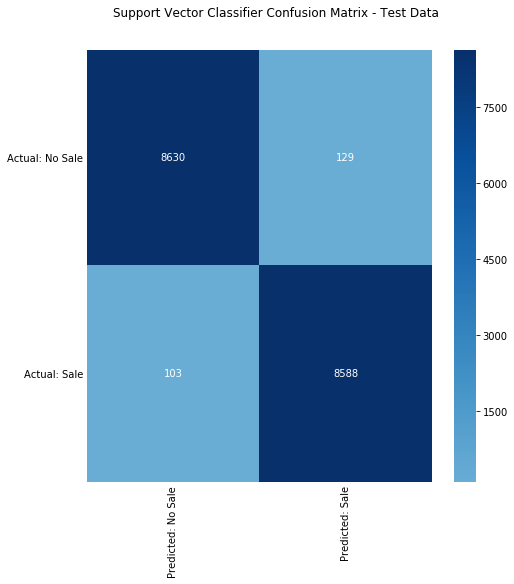

In [43]:
# visualize confusion matrix on seaborn heatmap
# pyplot subplots
fig, axes = plt.subplots(figsize=(7.5, 7.5))

# plot svc_con_matrix on seaborn heatmap
sns.heatmap(svc_con_matrix, cmap='Blues', annot=True, fmt='d', center=0, ax=axes)
# adjust rotation of x tick labels and y tick labels
axes.set_yticklabels(['Actual: No Sale', 'Actual: Sale'], rotation=0)
axes.set_xticklabels(['Predicted: No Sale', 'Predicted: Sale'], rotation=90)
# set tick properties
axes.tick_params(axis='both', which='both', length=0)

# adjust spacing properties of subplot
fig.subplots_adjust(left=0.15, right=0.95, bottom=0.1, top=0.9,
                    hspace=0.2, wspace=0.2)

# set title of subplot figure
fig.suptitle('Support Vector Classifier Confusion Matrix - Test Data')

# display heatmap
plt.show()

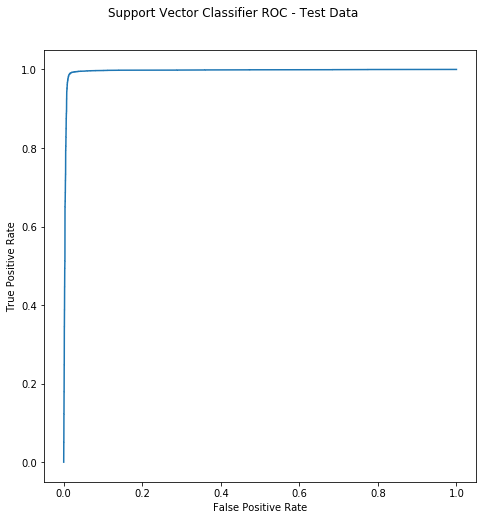

In [44]:
# plot roc curve for support vector classifier
# pyplot subplots
fig, axes = plt.subplots(figsize=(7.5, 7.5))

# obtain probabilities for roc curve
svc_fpr, svc_tpr, svc_thresholds = roc_curve(y_test['Sale'].to_numpy(), svc_best.predict_proba(X_test)[:, 1])

# plot true positive and false positive rates
plt.plot(svc_fpr, svc_tpr)
# set x-y axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# adjust spacing properties of subplot
fig.subplots_adjust(left=0.15, right=0.95, bottom=0.1, top=0.9,
                    hspace=0.2, wspace=0.2)

# set title of subplot figure
fig.suptitle('Support Vector Classifier ROC - Test Data')

# display roc
plt.show()

In [45]:
# display area under curve for support vector classifier
print('Support vector classifier - area under curve: %.4f' %(auc(svc_fpr, svc_tpr)))

Support vector classifier - area under curve: 0.9954


## Multi-layer Perceptron
The final machine model we will create will be a Multi-layer perceptron. The same procedure will be followed as that of the Random Forest Classifier and Support Vector Classifier above.

In [46]:
# initialize MLP classifier
mlp = MLPClassifier(random_state=2)

# specify parameter values that are to be explored when conducting random search
mlp_param_dist = {'hidden_layer_sizes':[(50, 50, 50), (100, 100, 100), (200, 200, 200), (300, 300, 300), (50, 50), (100, 100), (200, 200), (300, 300), (50,), (100,), (200,), (300,)],
                 'activation':['logistic', 'tanh', 'relu'],
                 'solver':['lbfgs', 'sgd', 'adam'],
                 'learning_rate':['constant', 'invscaling', 'adaptive']}

# conduct grid search and source model with best parameters
rs_cv_mlp = RandomizedSearchCV(estimator=mlp, param_distributions=mlp_param_dist, cv=5, n_iter=2, random_state=2, verbose=2)
# fit grid search to training data
rs_cv_mlp.fit(X_train, y_train['Sale'].to_numpy())

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] solver=lbfgs, learning_rate=adaptive, hidden_layer_sizes=(200, 200), activation=tanh 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  solver=lbfgs, learning_rate=adaptive, hidden_layer_sizes=(200, 200), activation=tanh, total= 2.5min
[CV] solver=lbfgs, learning_rate=adaptive, hidden_layer_sizes=(200, 200), activation=tanh 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s


[CV]  solver=lbfgs, learning_rate=adaptive, hidden_layer_sizes=(200, 200), activation=tanh, total= 2.2min
[CV] solver=lbfgs, learning_rate=adaptive, hidden_layer_sizes=(200, 200), activation=tanh 
[CV]  solver=lbfgs, learning_rate=adaptive, hidden_layer_sizes=(200, 200), activation=tanh, total= 2.1min
[CV] solver=lbfgs, learning_rate=adaptive, hidden_layer_sizes=(200, 200), activation=tanh 
[CV]  solver=lbfgs, learning_rate=adaptive, hidden_layer_sizes=(200, 200), activation=tanh, total= 2.2min
[CV] solver=lbfgs, learning_rate=adaptive, hidden_layer_sizes=(200, 200), activation=tanh 
[CV]  solver=lbfgs, learning_rate=adaptive, hidden_layer_sizes=(200, 200), activation=tanh, total= 2.3min
[CV] solver=lbfgs, learning_rate=adaptive, hidden_layer_sizes=(100, 100, 100), activation=logistic 
[CV]  solver=lbfgs, learning_rate=adaptive, hidden_layer_sizes=(100, 100, 100), activation=logistic, total= 1.8min
[CV] solver=lbfgs, learning_rate=adaptive, hidden_layer_sizes=(100, 100, 100), activatio

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 18.8min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_iter=200, momentum=0.9,
                                           n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           rand...
                   param_distributions={'activation': ['logistic', 'tanh',
                                                       'relu'],
                                        '

In [47]:
# display best set of hyperparameters from randomized search
rs_cv_mlp.best_params_

{'solver': 'lbfgs',
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (100, 100, 100),
 'activation': 'logistic'}

In [48]:
# train new multi-layer perceptron classifier model on best hyperparameters
mlp_best = MLPClassifier(random_state=2, solver=rs_cv_mlp.best_params_['solver'], learning_rate=rs_cv_mlp.best_params_['learning_rate'],
                         hidden_layer_sizes=rs_cv_mlp.best_params_['hidden_layer_sizes'], activation=rs_cv_mlp.best_params_['activation'])
# fit model to training set data
mlp_best.fit(X_train, y_train['Sale'].to_numpy())

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100, 100), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=2, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [49]:
# predict class labels for test set data
y_pred = mlp_best.predict(X_test)

# create confusion matrix for test set data to calculate performance metrics
mlp_con_matrix = confusion_matrix(y_test['Sale'].to_numpy(), y_pred)

In [50]:
# retrieve true positive, true negative, false positive, and false negative values from svc_con_matrix
tn = mlp_con_matrix[0][0]
fp = mlp_con_matrix[0][1]
fn = mlp_con_matrix[1][0]
tp = mlp_con_matrix[1][1]
# calculate the accuracy of the mlp model on the test set
mlp_accurarcy = (tp+tn)/(tp+tn+fp+fn)
# calculate the precision of the mlp model on the test set
mlp_precision = tp/(tp+fp)
# calculate the recall of the mlp model on the test set
mlp_recall = tp/(tp+fn)
# calculate the f1-score of the mlp model on the test set
mlp_f1_score = (2*(mlp_recall*mlp_precision))/(mlp_precision+mlp_recall)

# display multi-layer perceptron classifier model performance metrics calculated above
print('Multi-layer perceptron classifier accuracy: %.4f%%' %(mlp_accurarcy*100))
print('Multi-layer perceptron classifier precision: %.4f' %(mlp_precision))
print('Multi-layer perceptron classifier recall: %.4f' %(mlp_recall))
print('Multi-layer perceptron classifier f1-score: %.4f' %(mlp_f1_score))

Multi-layer perceptron classifier accuracy: 98.8309%
Multi-layer perceptron classifier precision: 0.9862
Multi-layer perceptron classifier recall: 0.9903
Multi-layer perceptron classifier f1-score: 0.9883


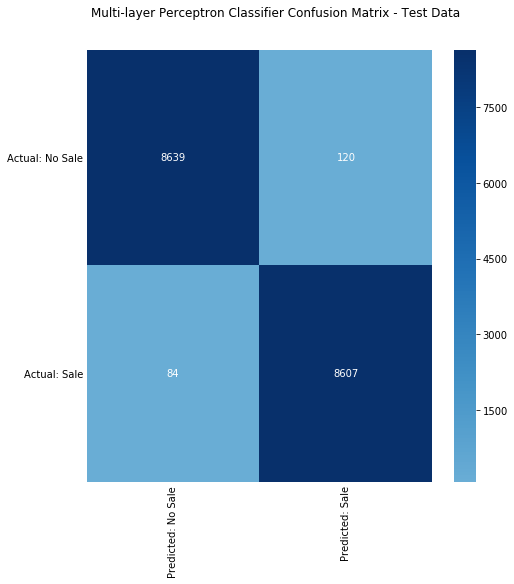

In [51]:
# visualize confusion matrix on seaborn heatmap
# pyplot subplots
fig, axes = plt.subplots(figsize=(7.5, 7.5))

# plot mlp_con_matrix on seaborn heatmap
sns.heatmap(mlp_con_matrix, cmap='Blues', annot=True, fmt='d', center=0, ax=axes)
# adjust rotation of x tick labels and y tick labels
axes.set_yticklabels(['Actual: No Sale', 'Actual: Sale'], rotation=0)
axes.set_xticklabels(['Predicted: No Sale', 'Predicted: Sale'], rotation=90)
# set tick properties
axes.tick_params(axis='both', which='both', length=0)

# adjust spacing properties of subplot
fig.subplots_adjust(left=0.15, right=0.95, bottom=0.1, top=0.9,
                    hspace=0.2, wspace=0.2)

# set title of subplot figure
fig.suptitle('Multi-layer Perceptron Classifier Confusion Matrix - Test Data')

# display heatmap
plt.show()

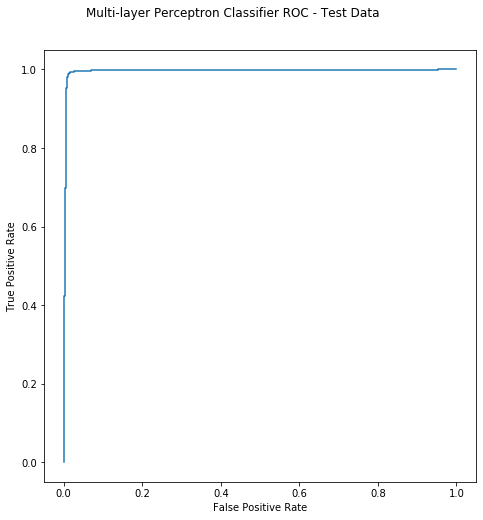

In [52]:
# plot roc curve for multi-layer perceptron classifier
# pyplot subplots
fig, axes = plt.subplots(figsize=(7.5, 7.5))

# obtain probabilities for roc curve
mlp_fpr, mlp_tpr, mlp_thresholds = roc_curve(y_test['Sale'].to_numpy(), mlp_best.predict_proba(X_test)[:, 1])

# plot true positive and false positive rates
plt.plot(mlp_fpr, mlp_tpr)
# set x-y axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# adjust spacing properties of subplot
fig.subplots_adjust(left=0.15, right=0.95, bottom=0.1, top=0.9,
                    hspace=0.2, wspace=0.2)

# set title of subplot figure
fig.suptitle('Multi-layer Perceptron Classifier ROC - Test Data')

# display roc
plt.show()

In [53]:
# display area under curve for multi-layer perceptron classifier
print('Multi-layer perceptron classifier - area under curve: %.4f' %(auc(mlp_fpr, mlp_tpr)))

Multi-layer perceptron classifier - area under curve: 0.9959
